## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
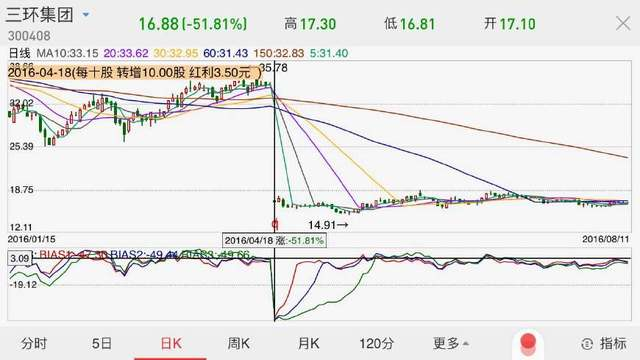

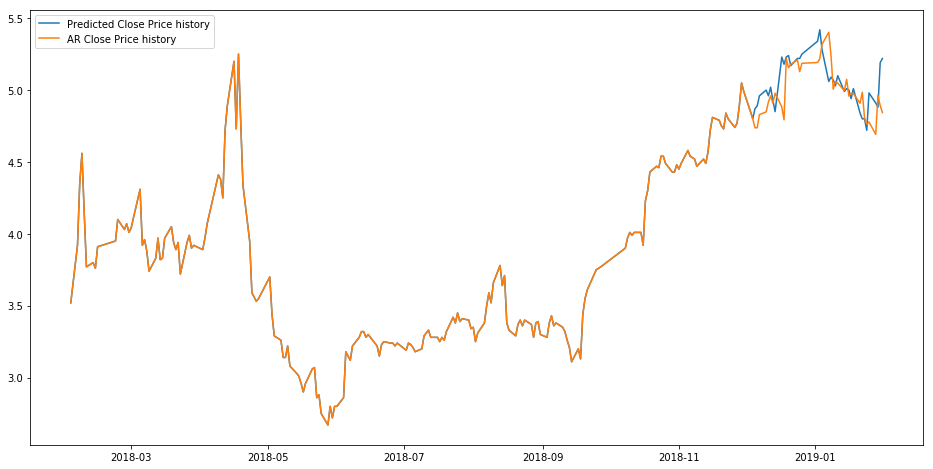

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob
import os
import matplotlib.pyplot as plt

os.chdir(r'D:\1-开课吧\03-人工智能与自然语言处理\第二章 人工智能引论与思维方法\第7节 如何处理时序问题？RNN循环神经网络及其应用\assignment-07数据集')

def find_files(path): 
    return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [3]:
# 构建category_lines字典，这是每种语言的名称列表
category_lines = {}
all_categories = []

# 读取文件并分成几行
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
# 所有分类
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [4]:
# 分类长度
n_categories

18

In [5]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
# 从all_letters中查找字母索引。“a”= 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
# 为了演示一下，把一个字母转化成一个<1 x n_letters>张量
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,   将一行转换为<line_length x 1 x n_letters>，
# or an array of one-hot letter vectors               或者是一个只有一个热门字母的向量数组
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [7]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

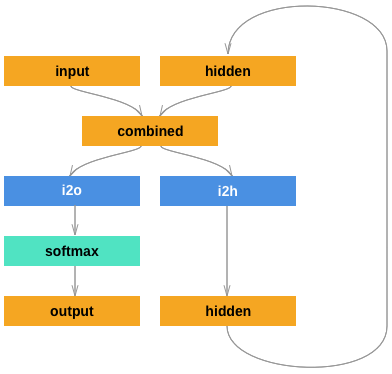

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [9]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [10]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [11]:
output

tensor([[-2.9108, -2.8321, -2.8207, -2.9703, -2.9779, -2.9260, -2.9005, -2.9232,
         -2.8849, -2.7816, -2.8179, -2.9178, -2.8746, -2.9387, -2.8782, -2.8957,
         -2.9325, -2.8674]], grad_fn=<LogSoftmaxBackward>)

In [12]:
next_hidden

tensor([[-0.0749, -0.0428, -0.1164,  0.0261, -0.0370,  0.0785,  0.0129,  0.0179,
          0.1021,  0.1016,  0.1217,  0.0855, -0.0618, -0.0943,  0.1089,  0.0856,
          0.0123,  0.0015, -0.0901, -0.0040, -0.0238, -0.0348,  0.0429, -0.0712,
          0.0100, -0.0691, -0.0740,  0.1071, -0.0095, -0.0518, -0.1284, -0.0050,
         -0.0665, -0.0617,  0.0917,  0.0377,  0.0188,  0.0134,  0.0402, -0.0552,
          0.0054, -0.1011, -0.0682, -0.0850,  0.0303,  0.0417,  0.1217, -0.0366,
         -0.0002,  0.0533,  0.0442, -0.0248,  0.0207, -0.0086,  0.0210, -0.0629,
         -0.0062, -0.0070, -0.0821, -0.0238,  0.0239, -0.0541,  0.1026,  0.0538,
         -0.0884, -0.0489,  0.0103,  0.0197, -0.1034,  0.0667,  0.0048, -0.0841,
          0.0021, -0.0772, -0.0057,  0.0798,  0.0515, -0.0340,  0.0114, -0.0253,
         -0.0582,  0.0509,  0.1141,  0.0660, -0.0379,  0.0036, -0.0233, -0.0351,
          0.0994,  0.0475, -0.0171, -0.0860,  0.0850,  0.0142,  0.0481,  0.0533,
         -0.1042,  0.1124, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [13]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9108, -2.8321, -2.8207, -2.9703, -2.9779, -2.9260, -2.9005, -2.9232,
         -2.8849, -2.7816, -2.8179, -2.9178, -2.8746, -2.9387, -2.8782, -2.8957,
         -2.9325, -2.8674]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [14]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [15]:
print(category_from_output(output))

('Italian', 9)


### 1.8 随机生成训练数据

In [16]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Czech / line = Ludwig
category = Arabic / line = Seif
category = Japanese / line = Onishi
category = Irish / line = Samuel
category = Polish / line = Winogrodzki
category = Vietnamese / line = Ngo
category = Russian / line = Mineev
category = Chinese / line = Bao
category = Italian / line = Caito
category = Greek / line = Leontarakis


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
# 如果设置得太高, 可能会爆炸. 如果太低, 可能无法学习.
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 将参数梯度添加到它们的值,再乘以学习速率
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [24]:
import time
import math

n_iters = 20000 # 这个数字你可以调大一些
print_every = 10000
plot_every = 100


# 跟踪绘图的损失
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # 打印循环数,损失,名称和猜测
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # 将当前损失平均值添加到损失清单
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 50% (0m 20s) 0.9182 Vives / Spanish ✓
20000 100% (0m 41s) 2.3990 Rose / French ✗ (German)


### 1.9 观察Loss的变化

In [25]:
# 选取前100观察
all_losses[:100]

[1.2468895366974175,
 1.28459337037988,
 1.212359068710357,
 1.2229265959374607,
 1.2672927006456303,
 1.1519714466342703,
 1.125517116030678,
 1.266374748982489,
 1.082339504554402,
 1.4207971023116261,
 1.1078127586096524,
 1.1712675321800634,
 1.224875581227243,
 1.3367574958724435,
 1.423769411314279,
 1.1090514384722336,
 1.398455840907991,
 1.2514010638464241,
 1.399077549399808,
 1.179019588045776,
 1.2957830274477602,
 1.2083011783566326,
 1.1180395593494177,
 1.1793152899830601,
 1.1880764510901645,
 1.2900203943881206,
 1.431492697680369,
 1.3512996105104684,
 1.3501435962785036,
 1.4340835168026387,
 1.4598210526630282,
 1.2344292822061107,
 1.179929118156433,
 1.2505517666600645,
 1.3541284524649382,
 0.9732202100381255,
 1.2011793370638042,
 1.2818430680781603,
 1.161242043673992,
 1.3866664838790894,
 1.3522417420556303,
 1.163217110252008,
 1.2681279914081096,
 1.0176604688633233,
 1.2987230577261653,
 1.331699722330086,
 1.3284138067625464,
 1.4105452144145965,
 1.27981

In [26]:
%matplotlib inline

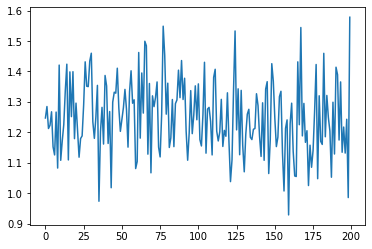

In [27]:
plt.plot(all_losses)

In [28]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.36) Russian
(-1.48) Czech
(-3.17) Polish

> Jackson
(-0.71) Scottish
(-1.29) English
(-2.77) French

> Satoshi
(-1.09) Italian
(-1.46) Japanese
(-1.95) Arabic


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

#### 为了方便测试，我们把测试的代码封装成函数

In [29]:
# 训练
def train(category_tensor, line_tensor, model, optimizer):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in model.parameters():
    #   p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [30]:
# 测试
def test(test_model, train_model, n_iters=10000, learning_rate=1e-3, printout=True, drawout=True):
    # 记录损失以备绘图
    current_loss = 0
    all_losses = []
    optimizer = torch.optim.Adam(test_model.parameters(), lr=learning_rate)

    start = time.time()
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_trainning()
        output, loss = train_model(category_tensor, line_tensor, test_model, optimizer)
        current_loss += loss
        # Print iter number, loss, name and guess
        if printout and iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    if drawout:
        plt.figure(figsize=(10,6))
        plt.plot(all_losses)
        
    return all_losses    

##### 尝试在combine时，增加一个层

In [31]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, comb_layer_size):
        super(RNN2, self).__init__()

        self.hidden_size = hidden_size
        
        # 增加的combine_layer
        self.combine_layer = nn.Linear(input_size + hidden_size, comb_layer_size)
        self.c2h = nn.Linear(comb_layer_size, hidden_size)
        self.c2o = nn.Linear(comb_layer_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        # 增加在combine_layer时做的前向计算
        comb_l = self.combine_layer(combined)
        hidden = self.c2h(comb_l)
        output = self.c2o(comb_l)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

##### 尝试在combine时，增加一个层后，再增加output层

In [32]:
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, comb_layer_size):
        super(RNN3, self).__init__()

        self.hidden_size = hidden_size
        
        # 增加的combine_layer
        self.combine_layer = nn.Linear(input_size + hidden_size, comb_layer_size)
        self.c2h = nn.Linear(comb_layer_size, hidden_size)
        self.c2o = nn.Linear(comb_layer_size, output_size)
        # 增加的o2o_layer
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        # 增加在combine_layer时做的前向计算
        comb_l = self.combine_layer(combined)
        hidden = self.c2h(comb_l)
        output = self.c2o(comb_l)
        # 增加在o2o_layer时做的前向计算
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

##### 尝试在combine时，增加一个层后，再增加output层和dropout层

In [33]:
class RNN4(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, comb_layer_size):
        super(RNN4, self).__init__()

        self.hidden_size = hidden_size
        
        # 增加的combine_layer
        self.combine_layer = nn.Linear(input_size + hidden_size, comb_layer_size)
        self.c2h = nn.Linear(comb_layer_size, hidden_size)
        self.c2o = nn.Linear(comb_layer_size, output_size)
        # 增加的o2o_layer
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        # 增加的dropout
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        # 增加在combine_layer时做的前向计算
        comb_l = self.combine_layer(combined)
        hidden = self.c2h(comb_l)
        output = self.c2o(comb_l)
        # 增加在o2o_layer时做的前向计算
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        # 增加dropout
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [34]:
n_hidden = 128
comb_layer_size = 64
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

In [35]:
rnn2 = RNN2(n_letters, n_hidden, n_categories, comb_layer_size)

In [36]:
rnn3 = RNN3(n_letters, n_hidden, n_categories, comb_layer_size)

In [37]:
rnn4 = RNN4(n_letters, n_hidden, n_categories, comb_layer_size)

10000 50% (0m 24s) 3.0114 Chew / Dutch ✗ (Chinese)
20000 100% (0m 48s) 2.1525 Jordan / Arabic ✗ (French)


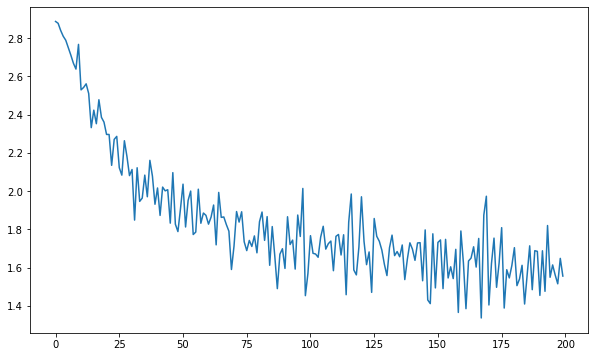

In [38]:
rnn2_losses = test(rnn2, train, n_iters=20000, learning_rate=learning_rate)

10000 50% (0m 30s) 1.1618 Chau / Chinese ✗ (Vietnamese)
20000 100% (1m 2s) 3.8546 Oshin / Irish ✗ (Japanese)


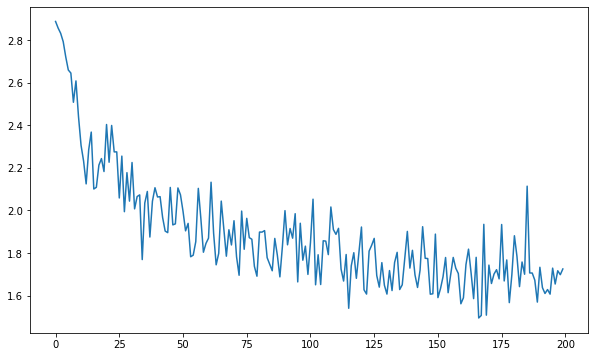

In [39]:
rnn3_losses = test(rnn3, train, n_iters=20000, learning_rate=learning_rate)

10000 50% (0m 34s) 1.7994 Palumbo / Portuguese ✗ (Italian)
20000 100% (1m 9s) 2.4189 Farrell / German ✗ (Irish)


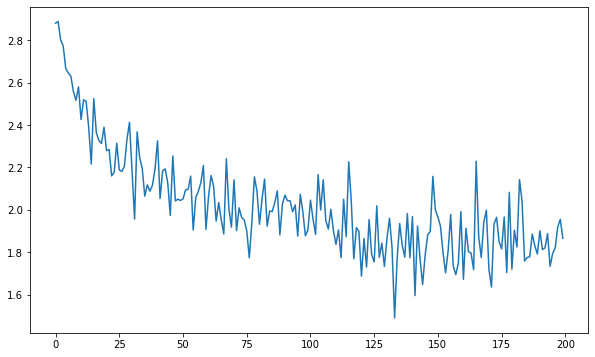

In [40]:
rnn4_losses = test(rnn4, train, n_iters=20000, learning_rate=learning_rate)

##### 下面我们把各个RNN的损失函数，绘制在同一figure看看

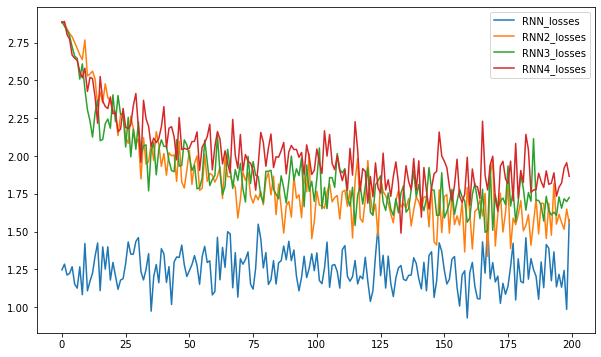

In [41]:
plt.figure(figsize=(10,6))
plt.plot(all_losses,label='RNN_losses')
plt.plot(rnn2_losses,label='RNN2_losses')
plt.plot(rnn3_losses,label='RNN3_losses')
plt.plot(rnn4_losses,label='RNN4_losses')
plt.legend()

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

#### 构建LSTM

In [42]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    # 这里的hidden指(h_n, c_n)
    def forward(self, input, hidden):
        out, hidden = self.lstm(input.reshape(1, 1, self.input_size), hidden)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out, hidden
    
    def initHidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size), torch.zeros(self.n_layers, 1, self.hidden_size))

In [43]:
lstm = LSTM(n_letters, n_hidden, n_categories, 1)

10000 50% (1m 11s) 2.9793 Olson / Scottish ✗ (English)
20000 100% (2m 19s) 1.9836 Shammas / Arabic ✓


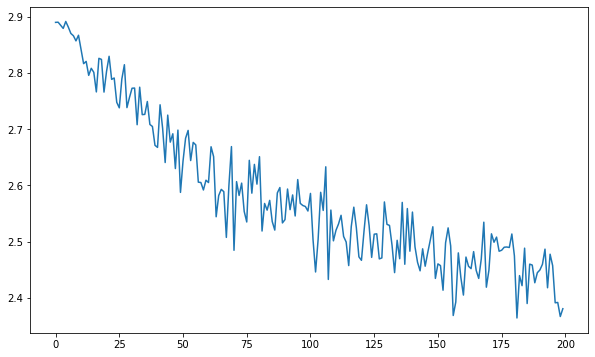

In [44]:
LSTM_losses = test(lstm, train, n_iters=20000, learning_rate=0.001)

#### 构建GRU

In [45]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input, hidden):
        out, hidden = self.gru(input.reshape(1, 1, self.input_size), hidden)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [46]:
gru = GRU(n_letters, n_hidden, n_categories, 1)

10000 50% (1m 2s) 1.9829 Isoda / Japanese ✓
20000 100% (2m 5s) 1.9819 Salib / Arabic ✓


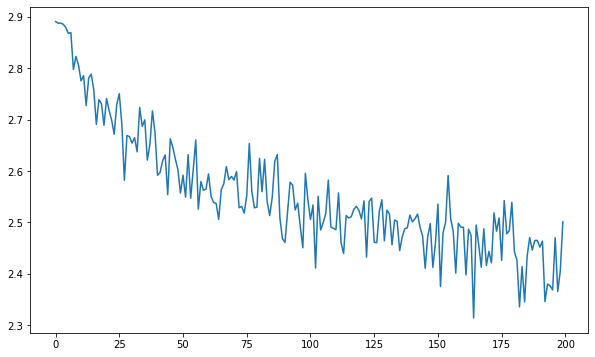

In [47]:
GRU_losses = test(gru, train, n_iters=20000, learning_rate=0.001)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [48]:
# n_layers = 2
lstm_2 = LSTM(n_letters, n_hidden, n_categories, 2)

10000 50% (1m 6s) 1.9844 Mackenzie / Scottish ✓
20000 100% (2m 12s) 2.2073 Borde / French ✓


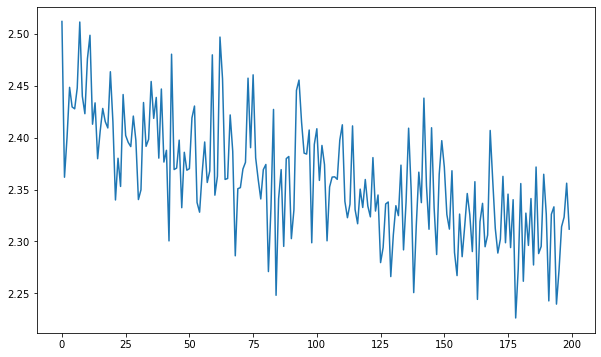

In [49]:
LSTM_2_losses = test(lstm, train, n_iters=20000, learning_rate=0.001)

In [50]:
# n_layers = 2
gru_2 = GRU(n_letters, n_hidden, n_categories, 2)

10000 50% (1m 2s) 1.9854 Franco / Portuguese ✓
20000 100% (2m 4s) 1.9853 Bukowski / Polish ✓


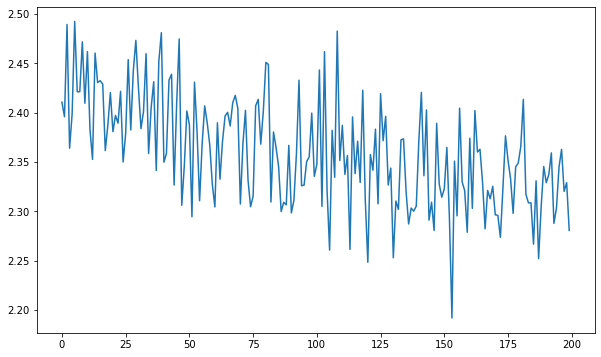

In [51]:
GRU_2_losses = test(gru, train, n_iters=20000, learning_rate=0.001)

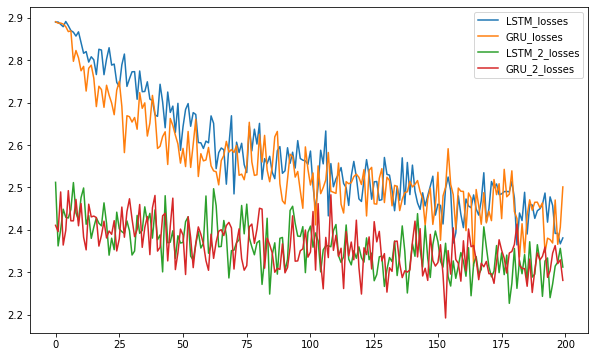

In [52]:
plt.figure(figsize=(10,6))
plt.plot(LSTM_losses,label='LSTM_losses')
plt.plot(GRU_losses,label='GRU_losses')
plt.plot(LSTM_2_losses,label='LSTM_2_losses')
plt.plot(GRU_2_losses,label='GRU_2_losses')
plt.legend()

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

#### 损失函数NLLLoss() 的 输入 是一个对数概率向量和一个目标标签. 它不会为我们计算对数概率，适合最后一层是log_softmax()的网络. 损失函数 CrossEntropyLoss() 与 NLLLoss() 类似, 唯一的不同是它为我们去做 softmax.可以理解为：

#### CrossEntropyLoss()=log_softmax() + NLLLoss() 

In [53]:
criterion = nn.NLLLoss()

In [54]:
# 训练
def train(category_tensor, line_tensor, model, optimizer):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    # 用nn.NLLLoss()代替 nn.CrossEntropyLoss()
    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in model.parameters():
    #   p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [55]:
# NLL Loss需要用logsoftmax
class GRU2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        out, hidden = self.gru(input.reshape(1, 1, self.input_size), hidden)
        out = self.fc(out[:, -1, :])
        out = self.logsoftmax(out)
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [56]:
gru_NLLLoss = GRU2(n_letters, n_hidden, n_categories, 2)

10000 50% (2m 2s) 1.3012 Kleid / German ✓
20000 100% (4m 11s) 2.4507 Abreu / Portuguese ✗ (Spanish)


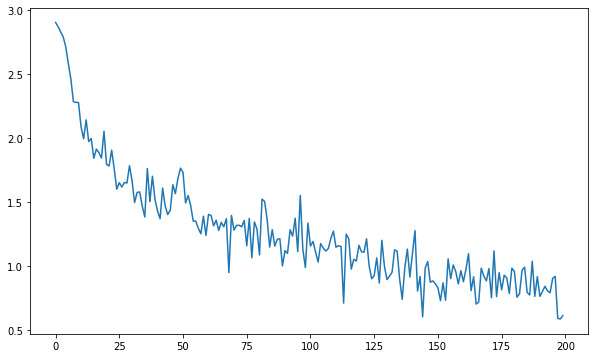

In [57]:
GRU_NLLLoss_losses = test(gru_NLLLoss, train, n_iters=20000, learning_rate=0.001)

#### 为了测试各个模型预测效果，改写一下predict函数

In [58]:
def evaluate(line_tensor, model):
    hidden = model.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def predict(input_line, model, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line), model)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [59]:
predict('liang',rnn2)
predict('liang',rnn3)
predict('liang',rnn4)


> liang
(-1.44) Scottish
(-1.56) Irish
(-1.75) Vietnamese

> liang
(-1.62) Vietnamese
(-2.05) Irish
(-2.14) German

> liang
(-0.84) Chinese
(-1.16) Vietnamese
(-1.88) Korean


In [60]:
predict('liang',lstm)
predict('liang',gru)


> liang
(0.93) Italian
(0.05) Irish
(0.01) Czech

> liang
(0.43) Irish
(0.26) French
(0.10) Italian


In [61]:
predict('liang',lstm_2)
predict('liang',gru_2)


> liang
(0.06) English
(0.06) Dutch
(0.06) French

> liang
(0.06) Spanish
(0.06) Japanese
(0.06) Irish


In [62]:
predict('liang',gru_NLLLoss)


> liang
(-0.43) Irish
(-2.32) English
(-2.87) French


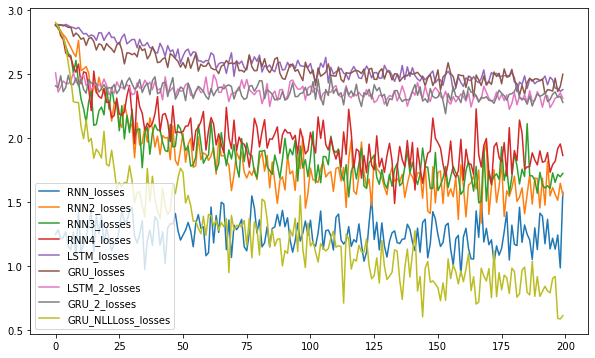

In [63]:
plt.figure(figsize=(10,6))
plt.plot(all_losses,label='RNN_losses')
plt.plot(rnn2_losses,label='RNN2_losses')
plt.plot(rnn3_losses,label='RNN3_losses')
plt.plot(rnn4_losses,label='RNN4_losses')
plt.plot(LSTM_losses,label='LSTM_losses')
plt.plot(GRU_losses,label='GRU_losses')
plt.plot(LSTM_2_losses,label='LSTM_2_losses')
plt.plot(GRU_2_losses,label='GRU_2_losses')
plt.plot(GRU_NLLLoss_losses,label='GRU_NLLLoss_losses')
plt.legend()